In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

## Set all the constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object

In [3]:
#tenserflow data input pipeline
#loaded data innto tenserflow datasets
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)#every element in the dataset is a batch of 32 images, and the last batch is not full

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


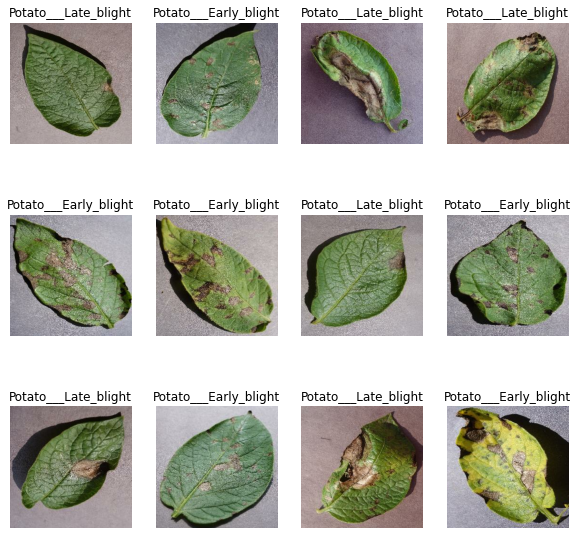

In [21]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

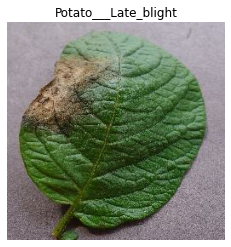

In [12]:
plt.imshow(image_batch[1].numpy().astype("uint8"))
plt.title(class_names[label_batch[1]])
plt.axis("off")

# Split train and test data

80 % : training
10% validation, 10% test
after 50 epochs: use 10% to test accuracy

In [22]:
len(dataset)

68

In [40]:
train_size= 0.8
val_size = 0.1
int(len(dataset)*train_size)


54

In [32]:
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [36]:
temp = dataset.skip(54)
len(temp)

14

In [37]:

len(dataset)*val_size

6.800000000000001

In [39]:
val_ds = temp.take(int(len(dataset)*val_size))
len(val_ds)

6

In [45]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1, test_split= 0.1, shuffle= True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed= 12)
    
    train_size = int(train_split* ds_size)
    val_size = int(val_split* ds_size)
    test_size = int(test_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [51]:
train_ds = train_ds.cach().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #shuffle images if gpu is training cpu going to load the next batch , prefetch() and cache()
val_ds = val_ds.cach().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cach().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

AttributeError: 'TakeDataset' object has no attribute 'cach'

# Image preprocessing

Creating layers for preprocessing

## 1.scaling

In [54]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## 2.Data augmentation 

Create four new  training samples out of the same image:
- Horizontal & vertical Flip
- Contrast
- Rotation
- Zoom


In [57]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model building

CNN: using
- convolution+ Relu layer 
- pooling : taking max in the matrix after convolution 
- convolution + Relu
- Pooling,

In [61]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes= 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape= input_shape)

In [63]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [65]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [66]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 78s 1s/step - loss: 0.9373 - accuracy: 0.4818 - val_loss: 0.8932 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 82s 1s/step - loss: 0.7988 - accuracy: 0.6221 - val_loss: 0.5525 - val_accuracy: 0.7798
Epoch 3/50
54/54 [==============================] - 90s 2s/step - loss: 0.5311 - accuracy: 0.7726 - val_loss: 0.3504 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 88s 2s/step - loss: 0.3151 - accuracy: 0.8756 - val_loss: 0.3165 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 92s 2s/step - loss: 0.3033 - accuracy: 0.8791 - val_loss: 0.3736 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2450 - accuracy: 0.8985 - val_loss: 0.2202 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 90s 2s/step - loss: 0.2370 - accuracy: 0.9137 - val_loss: 0.2237 - val_accuracy: 0.9271
Epoch 8/50
54/54 [==

In [67]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 4s 327ms/step - loss: 0.0138 - accuracy: 0.9961


[0.013789048418402672, 0.99609375]

In [68]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validating Accuracy')

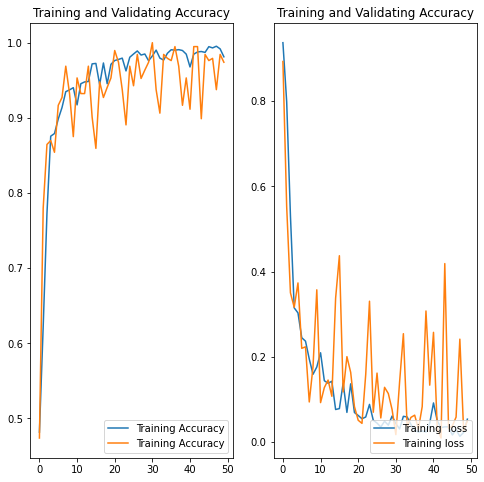

In [71]:
plt.figure(figsize = (8,8))

plt.subplot(1,2,1)

plt.plot(range(EPOCHS), acc , label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc , label='Training Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validating Accuracy')


plt.subplot(1,2,2)

plt.plot(range(EPOCHS), loss , label='Training  loss')
plt.plot(range(EPOCHS), val_loss , label='Training loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validating Accuracy')

first image to predict
first image's actual label:  Potato___Early_blight
[9.9998295e-01 1.7014298e-05 8.2500247e-15]
predicted label:  Potato___Early_blight


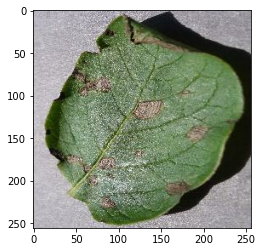

In [77]:
import numpy as np
for images_batch, label_batch in test_ds.take(1):
    
    print('first image to predict')
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    print("first image's actual label: ", class_names[label_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [99]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img) 
    img_array = tf.expand_dims(img_array,0) #Create a batch
    #add batch dimension
    
    predictions = model.predict(img_array)
    
    predicted_class= class_names(np.argmax(predictions[0]))
    confidence = round(100 * np.max(predicitons[0]),2)
    return predicted_class, confidence
    

In [107]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

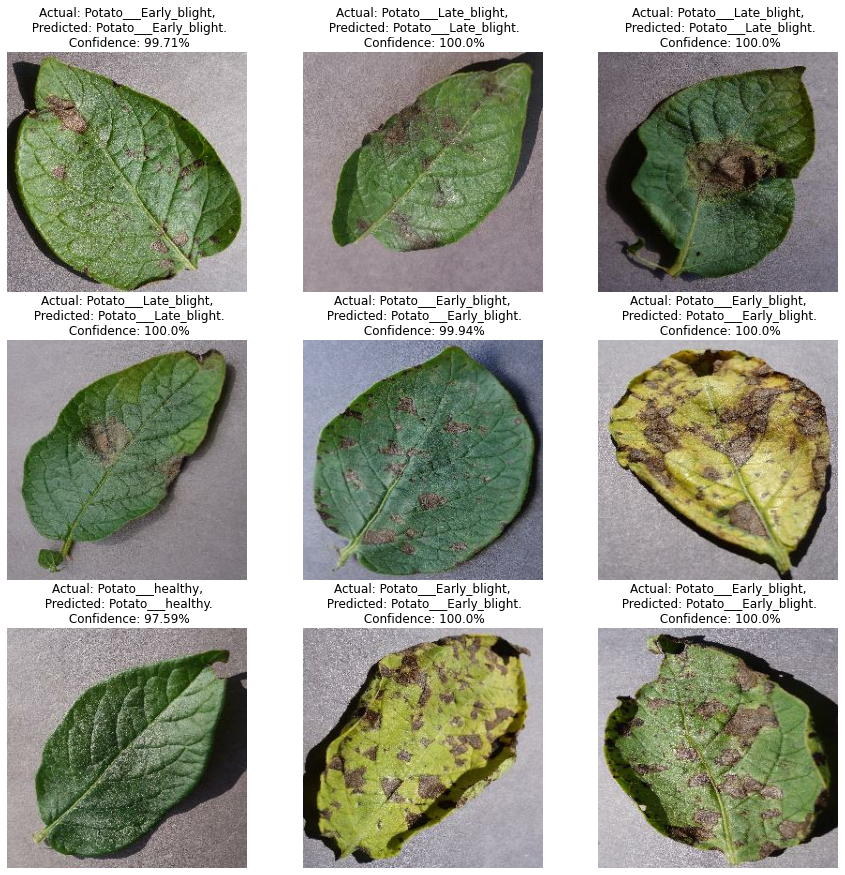

In [108]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


# Saving the model

In [104]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [106]:
model.save("./potatoes.h5")